#### Various RNN models will be built and their forecasts will be compared

In [1]:
#Import libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.contrib.keras import models, layers
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('./UK Pop X Age.csv', index_col=0)

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Data Exploration

In [2]:
df.head()

,% of pop 0-19 years,% of pop 20-39 years,% of pop 40-59 years,% of pop 60-79 years,% of pop 80+ years
TIME,,,,,
1954,28.884462,27.689243,27.091633,14.541833,1.792829
1955,29.300000,27.300000,27.100000,14.500000,1.800000
1956,29.488465,26.880642,27.281846,14.543631,1.805416
1957,29.540918,26.846307,27.045908,14.770459,1.796407
1958,29.640719,26.746507,26.946108,14.970060,1.696607


Figures are proportions

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 1954 to 2017
Data columns (total 5 columns):
% of pop 0-19 years     64 non-null float64
% of pop 20-39 years    64 non-null float64
% of pop 40-59 years    64 non-null float64
% of pop 60-79 years    64 non-null float64
% of pop 80+ years      64 non-null float64
dtypes: float64(5)
memory usage: 3.0 KB


The series start in 1954 and terminates in 2017

Text(0,0.5,'Proportion')

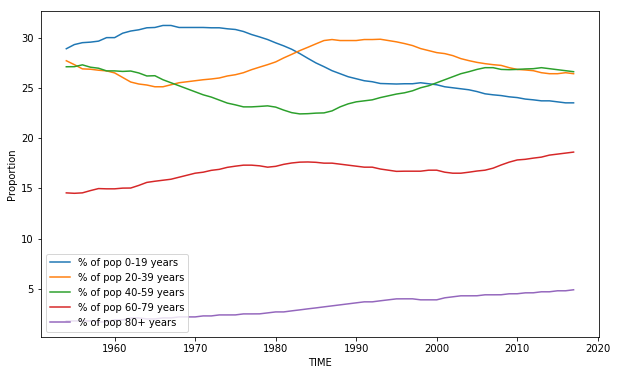

In [4]:
chart = df.plot(figsize = (10,6))
chart.legend(loc='best')
chart.set_ylabel('Proportion')

We can see that in general the UK is getting older

#### Let's get modelling!

In [5]:
#Some helper functions for making an LSTM model and plotting the results:

#After some light experimentation this model seemed to be the most accurate (for the model with sequence inputs)
#dropout layers did not boost performance
def makeModel(timesteps, features, outputs):
    model = models.Sequential()
    model.add(layers.LSTM(16, input_shape=(timesteps, features),activation = 'relu', return_sequences = True))
    model.add(layers.LSTM(32,activation = 'relu', return_sequences = True))
    model.add(layers.LSTM(16,activation = 'relu'))
    model.add(layers.Dense(outputs))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model
    
def resultPlot(y_pred, year):    
    #inverse transform
    preddy = scaler.inverse_transform(y_pred)
    #plot
    preddyDF = pd.DataFrame(preddy, columns = df.columns)
    preddyDF.index = df.iloc[-len(y_pred):].index
    preddyDF.columns = [x + '_pred' for x in preddyDF.columns]
    pd.concat((df.loc[year:],preddyDF), axis=1).plot(ylim = 0, figsize = (15,9))

In [6]:
#split and scale
split = 2004 #roughly an 80-20 split

train = df.loc[:split]
test = df.loc[split+1:]

scaler = MinMaxScaler()
train_scaled  = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#Make X and y sets for model fitting.
X_train = train_scaled[:-1]
y_train = train_scaled[1:]

X_test = test_scaled[:-1]
y_test = test_scaled[1:]

print('X_train shape: {}'.format(X_train.shape))

X_train shape: (50, 5)


In [7]:
# change shape to (batch, timesteps, features), one time step for now.
X_train = X_train[:, None]
X_test = X_test[:, None]
print('X_train shape: {}'.format(X_train.shape))

X_train shape: (50, 1, 5)


In [8]:
#make model
model1 = makeModel(1,5,5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             1408      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             6272      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
#fit model
model1.fit(X_train, y_train, epochs = 4000, verbose = 0)

In [29]:
print('Model Loss: {}'.format(model1.history.history['loss'][-1]))

Model Loss: 0.0002612935588695109


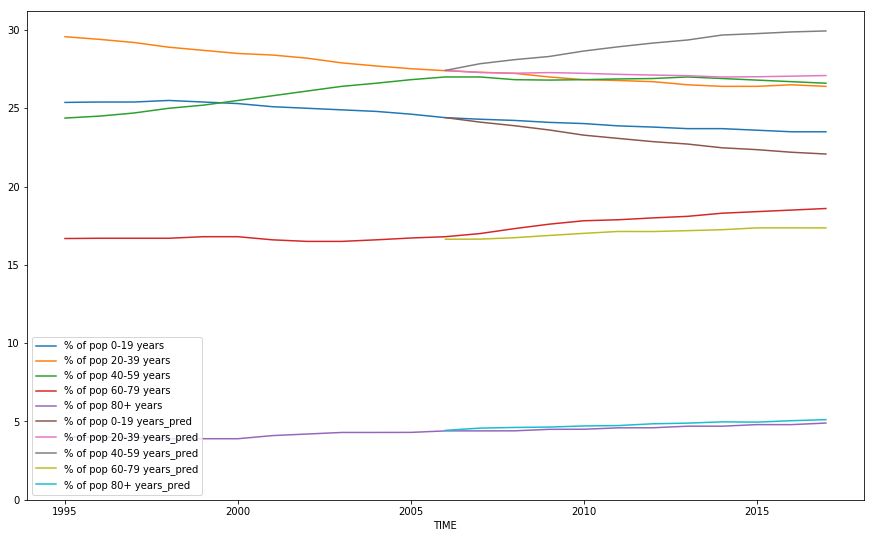

In [10]:
#Make predictions, inverse transform, plot against test data
y_pred = model1.predict(X_test)
resultPlot(y_pred, 1995)

This seems okay. 20-39 and 60-79 have not been predicted well though

###### Let's see what happens if we introduce a 4 year window period

This is a time series after all. Perhaps more than just the prior year had an impact on the current year

In [11]:
#Create 3 sets of shifted columns to get a 4 year period. This is done on the scaled data, not the orignal data!
window = pd.DataFrame(np.concatenate((train_scaled, test_scaled)), columns = df.columns, index = df.index)
for s in [1,2,3]:
    for col, item in df.iteritems():
        window[col + '_' + str(s)] = window[col].shift(s)

window = window.loc[1960:] 
window.head()

,% of pop 0-19 years,% of pop 20-39 years,% of pop 40-59 years,% of pop 60-79 years,% of pop 80+ years,% of pop 0-19 years_1,% of pop 20-39 years_1,% of pop 40-59 years_1,% of pop 60-79 years_1,% of pop 80+ years_1,% of pop 0-19 years_2,% of pop 20-39 years_2,% of pop 40-59 years_2,% of pop 60-79 years_2,% of pop 80+ years_2,% of pop 0-19 years_3,% of pop 20-39 years_3,% of pop 40-59 years_3,% of pop 60-79 years_3,% of pop 80+ years_3
TIME,,,,,,,,,,,,,,,,,,,,
1960,0.810933,0.291646,0.876726,0.142684,0.080322,0.810933,0.334059,0.876726,0.142684,0.003268,0.756362,0.348111,0.931227,0.150775,0.000000,0.740768,0.369211,0.951670,0.086752,0.038335
1961,0.879755,0.195784,0.865785,0.165195,0.078857,0.810933,0.291646,0.876726,0.142684,0.080322,0.810933,0.334059,0.876726,0.142684,0.003268,0.756362,0.348111,0.931227,0.150775,0.000000
1962,0.913557,0.099822,0.873986,0.168358,0.150936,0.879755,0.195784,0.865785,0.165195,0.078857,0.810933,0.291646,0.876726,0.142684,0.080322,0.810933,0.334059,0.876726,0.142684,0.003268
1963,0.932692,0.058062,0.834423,0.251704,0.154143,0.913557,0.099822,0.873986,0.168358,0.150936,0.879755,0.195784,0.865785,0.165195,0.078857,0.810933,0.291646,0.876726,0.142684,0.080322
1964,0.963911,0.036941,0.773033,0.347835,0.115770,0.932692,0.058062,0.834423,0.251704,0.154143,0.913557,0.099822,0.873986,0.168358,0.150936,0.879755,0.195784,0.865785,0.165195,0.078857


In [12]:
#Get the train and test data
split = 2004 

train = window.loc[:split]
test = window.loc[split+1:]

X_train = train.values[:-1]
y_train = train.values[1:,:5] #only need first 5 cols

X_test = test.values[:-1]
y_test = test.values[1:,:5] #only need first 5 cols

#Reshape to appropraite model input: (batch, timesteps, features)
X_train = X_train[:, None]
X_test = X_test[:, None]

print('X_train shape: {}'.format(X_train.shape))

X_train shape: (44, 1, 20)


In [13]:
#make model
model2 = makeModel(1,20,5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 16)             2368      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 32)             6272      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 11,861
Trainable params: 11,861
Non-trainable params: 0
_________________________________________________________________


In [14]:
#fit model
model2.fit(X_train, y_train, epochs = 4000, verbose = 0)

In [31]:
print('Model Loss: {}'.format(model2.history.history['loss'][-1]))

Model Loss: 0.00013249235185371205


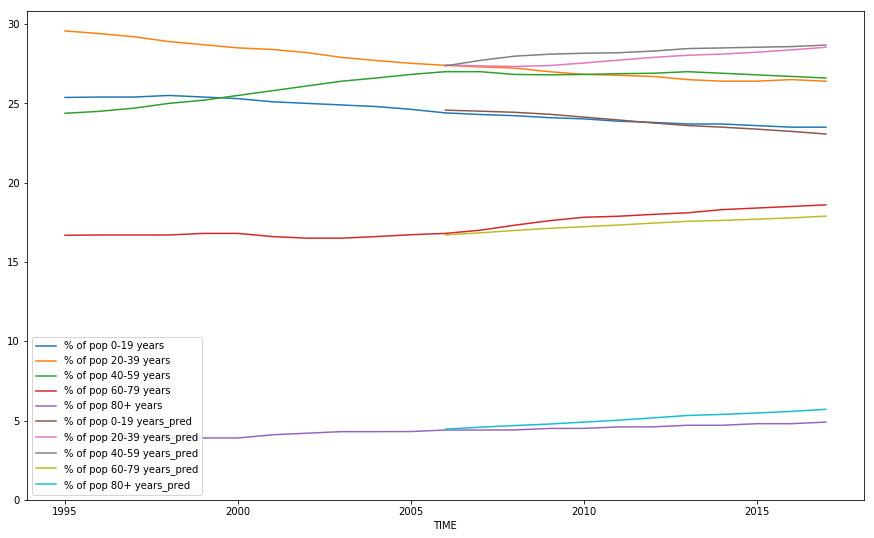

In [15]:
#Make predictions, inverse transform, plot against test data
y_pred = model2.predict(X_test)
resultPlot(y_pred, 1995)

40-59 years is now much worse than before. The other two problematic brakects have not improved either

###### This hasnt really helped. Lets try feeding in 4 year sequences

In [16]:
#Reshape to sequences
X_train = X_train.reshape(44 , 4, 5)
X_test = X_test.reshape(12, 4, 5)

print('X_train shape: {}'.format(X_train.shape))

X_train shape: (44, 4, 5)


In [17]:
#make model
model3 = makeModel(4,5,5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4, 16)             1408      
_________________________________________________________________
lstm_7 (LSTM)                (None, 4, 32)             6272      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
#fit model
model3.fit(X_train, y_train, epochs = 4000, verbose = 0)

In [32]:
print('Model Loss: {}'.format(model3.history.history['loss'][-1]))

Model Loss: 0.00019186720336702737


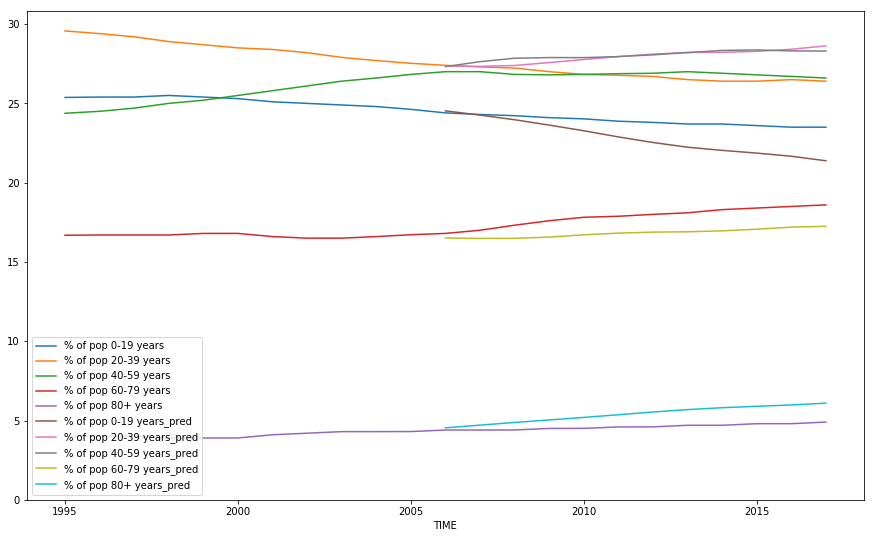

In [19]:
#Make predictions, inverse transform, plot against test data
y_pred = model3.predict(X_test)
resultPlot(y_pred, 1995)

It seems that a windowed approach has just introduced over fitting. Feeding the model sequences has not helped.

#### So was this better than just forecasting each series individually?

In [20]:
#We'll continue to use 4 year sequences as inputs
#Each feature column will be fitted and predicted separately
model_indv = makeModel(4,1,1)

preds = np.zeros((12,5))

for i in range(5):
    X_train_indv = X_train[:,:,None,i].copy()
    X_test_indv = X_test[:,:,None,i].copy()
    y_train_indv = y_train[:,None, i].copy()
    y_test_indv = y_test[:,None, i].copy()
    
    model_indv.fit(X_train_indv, y_train_indv, epochs = 4000, verbose = 0)
    y_pred = model_indv.predict(X_test_indv)
    preds[:,i] = y_pred.reshape(12)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 4, 16)             1152      
_________________________________________________________________
lstm_10 (LSTM)               (None, 4, 32)             6272      
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 10,577
Trainable params: 10,577
Non-trainable params: 0
_________________________________________________________________


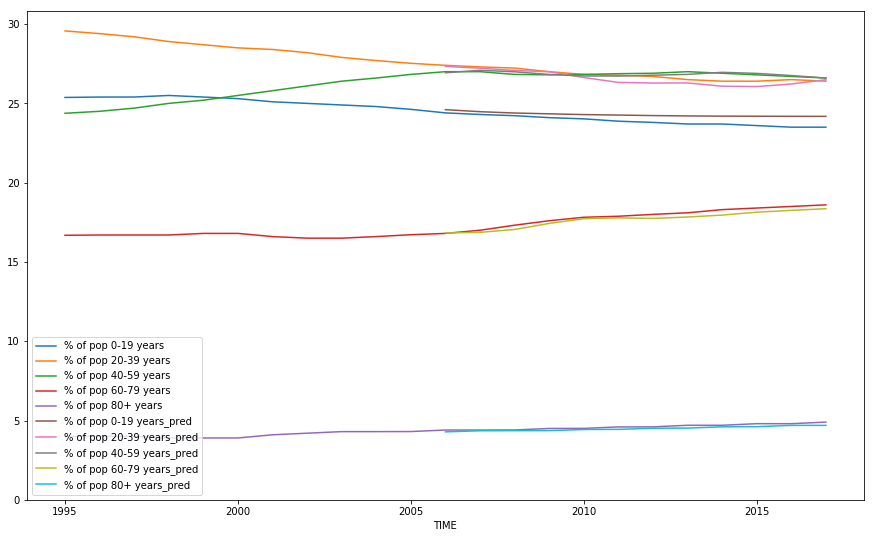

In [21]:
resultPlot(preds, 1995)

This output is far better than the prior models. Each feature can be accurately predicted independent of the other features. Making models that considered all age brackets at once did not make for accurate forecasts. Over fitting is the most likely reason for this. The additional variables just introduced more noise.

This investigation is far from extensive. Perhaps with the right tweaks a multi output model could be superior. The structure of the network could be changed, different activation functions could be used and alternative cells might also improve the output (e.g. GRU cells).

However the dataset is rather simple. We see here that 5 simple models can still get the job done. Only with a complex feature set might it be worth experimenting further.